In [6]:
!pip install gensim
!pip install matplotlib
!pip install -U scikit-learn
!pip install torch_geometric
!pip install networkx
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117

Looking in indexes: https://download.pytorch.org/whl/cu117
  Using cached https://download.pytorch.org/whl/cu117/torch-2.0.1%2Bcu117-cp38-cp38-win_amd64.whl (2343.7 MB)
  Using cached https://download.pytorch.org/whl/cu117/torchvision-0.15.2%2Bcu117-cp38-cp38-win_amd64.whl (4.9 MB)
  Using cached https://download.pytorch.org/whl/cu117/torchaudio-2.0.2%2Bcu117-cp38-cp38-win_amd64.whl (2.5 MB)
  Using cached https://download.pytorch.org/whl/filelock-3.9.0-py3-none-any.whl (9.7 kB)
  Using cached https://download.pytorch.org/whl/sympy-1.11.1-py3-none-any.whl (6.5 MB)
  Using cached https://download.pytorch.org/whl/mpmath-1.2.1-py3-none-any.whl (532 kB)


#  Graph  Construction

In [7]:
import networkx as nx
import random
from torch_geometric.datasets import KarateClub
from torch_geometric.utils import to_networkx

In [8]:
dataset = KarateClub()[0]

In [9]:
dataset

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])

In [10]:
dataset.y

tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0,
        2, 2, 0, 0, 2, 0, 0, 2, 0, 0])

In [11]:
karate_graph = to_networkx(dataset)

for node in karate_graph.nodes:
    karate_graph.nodes[node]["class"] = dataset.y.tolist()[node]
    

In [12]:
karate_graph.nodes(data=True)

NodeDataView({0: {'class': 1}, 1: {'class': 1}, 2: {'class': 1}, 3: {'class': 1}, 4: {'class': 3}, 5: {'class': 3}, 6: {'class': 3}, 7: {'class': 1}, 8: {'class': 0}, 9: {'class': 1}, 10: {'class': 3}, 11: {'class': 1}, 12: {'class': 1}, 13: {'class': 1}, 14: {'class': 0}, 15: {'class': 0}, 16: {'class': 3}, 17: {'class': 1}, 18: {'class': 0}, 19: {'class': 1}, 20: {'class': 0}, 21: {'class': 1}, 22: {'class': 0}, 23: {'class': 0}, 24: {'class': 2}, 25: {'class': 2}, 26: {'class': 0}, 27: {'class': 0}, 28: {'class': 2}, 29: {'class': 0}, 30: {'class': 0}, 31: {'class': 2}, 32: {'class': 0}, 33: {'class': 0}})

# Random Walk

In [13]:
'''
    graph : Graph
    start_node : start_node of random walk sequence
    num_steps : the length of random walk sequnce
'''
def random_walk(graph, start_node, num_steps):
    result = []
    current_node = start_node
    for _ in range(num_steps):
        result.append(current_node)
        neighbors = list(graph .neighbors(current_node))
        if not neighbors:
            break
        current_node = random.choice(neighbors)

    return result

In [14]:
start_node = random.choice(list(karate_graph.nodes()))
num_steps = 10  # the number of steps for random walk (length of sequence)

print("Random Walk:")

result = random_walk(karate_graph, start_node, num_steps)
print(result)

Random Walk:
[24, 25, 24, 31, 33, 27, 23, 29, 33, 26]


# Deep Walk Code

In [15]:
import numpy as np
import random
from gensim.models import Word2Vec
from torch.utils.data import Dataset
from functools import partial

__building dataset__

In [16]:
dataset = [random_walk(karate_graph, start_node=random.choice(list(karate_graph.nodes)), num_steps=20) for _ in range(100)]

In [17]:
for seq in dataset:
    print(seq)

[12, 0, 8, 32, 31, 32, 31, 33, 20, 33, 27, 23, 25, 23, 25, 31, 25, 31, 28, 33]
[19, 1, 30, 32, 29, 33, 23, 27, 24, 25, 31, 25, 24, 27, 2, 27, 24, 31, 0, 12]
[22, 33, 14, 32, 8, 33, 31, 24, 25, 31, 32, 29, 32, 15, 32, 14, 33, 15, 33, 23]
[17, 0, 10, 5, 0, 5, 16, 6, 0, 2, 9, 33, 31, 0, 21, 1, 2, 27, 33, 26]
[10, 4, 6, 16, 5, 10, 4, 10, 4, 6, 0, 17, 1, 17, 1, 13, 33, 20, 32, 30]
[28, 33, 22, 32, 29, 33, 28, 31, 32, 30, 1, 21, 1, 30, 33, 30, 8, 30, 8, 30]
[4, 10, 4, 10, 0, 1, 30, 32, 15, 33, 22, 32, 8, 30, 33, 23, 32, 30, 1, 21]
[0, 6, 0, 7, 3, 13, 3, 13, 0, 19, 33, 13, 0, 21, 1, 17, 1, 3, 1, 7]
[30, 32, 18, 33, 32, 15, 33, 29, 26, 33, 26, 29, 26, 29, 33, 22, 32, 29, 26, 29]
[16, 5, 6, 5, 10, 5, 6, 4, 0, 6, 5, 6, 16, 5, 16, 6, 5, 0, 5, 10]
[18, 32, 22, 33, 18, 33, 29, 26, 33, 23, 32, 18, 33, 32, 8, 33, 9, 33, 19, 0]
[13, 1, 3, 2, 3, 12, 0, 1, 30, 32, 22, 32, 30, 32, 31, 33, 20, 33, 9, 2]
[15, 32, 8, 30, 8, 33, 28, 2, 1, 19, 33, 22, 33, 8, 2, 32, 30, 1, 2, 32]
[14, 32, 14, 32, 23, 33, 31, 3

__running DeepWalk__

In [18]:
deepwalk = Word2Vec(dataset, vector_size=300, epochs=100)

In [19]:
deepwalk.wv[1]

array([-1.50211200e-01,  2.33525410e-01, -1.47464415e-02, -4.16863430e-03,
       -1.80696458e-01, -8.66290182e-03, -7.31902346e-02,  2.64846295e-01,
       -2.25035865e-02, -1.98129073e-01,  2.13516548e-01, -5.73485866e-02,
       -2.20651831e-03,  6.84520006e-02, -5.98334782e-02, -1.59814984e-01,
        2.66126603e-01, -2.06987739e-01,  3.21227871e-02, -1.21474393e-01,
        3.88261415e-02, -2.71410849e-02, -5.67215607e-02,  1.72406942e-01,
       -1.82234477e-02, -1.45819411e-02, -2.29152337e-01,  7.29453936e-02,
       -5.34891821e-02, -1.45311639e-01, -1.32833838e-01,  4.05641235e-02,
        1.51499316e-01, -1.55710474e-01, -4.52301539e-02,  3.59149091e-02,
        3.42493318e-02, -1.30265743e-01, -7.98118208e-03, -7.18161697e-03,
       -1.40422717e-01,  1.10179849e-01,  6.83035050e-03, -1.40051395e-01,
        7.36442432e-02, -8.44471678e-02,  4.73861629e-03,  5.87529242e-02,
        6.88847452e-02,  1.35904580e-01,  2.41024839e-03,  1.59015089e-01,
       -1.12818964e-01,  

# Node2Vec Code

__Random Walk Code for Node2Vec__

In [20]:
def node2vec_walk(G, start_node, num_steps, p, q):
    walk = [start_node]

    for _ in range(num_steps - 1):
        current_node = walk[-1]
        neighbors = list(G.neighbors(current_node))

        if len(neighbors) > 0:
            if len(walk) == 1:
                next_node = random.choice(neighbors)
            else:
                next_node = node2vec_weighted_choice(G, current_node, walk[-2], p, q)

            walk.append(next_node)
        else:
            break

    return walk

def node2vec_weighted_choice(G, current_node, previous_node, p, q):
    neighbors = list(G.neighbors(current_node))
    unnormalized_weights = []

    for neighbor in neighbors:
        if neighbor == previous_node:
            unnormalized_weights.append(1.0 / p)
        elif G.has_edge(current_node, neighbor):
            unnormalized_weights.append(1.0)
        else:
            unnormalized_weights.append(1.0 / q)

    norm_weights = [weight / sum(unnormalized_weights) for weight in unnormalized_weights]
    return random.choices(neighbors, weights=norm_weights)[0]

In [21]:
dataset2 = [node2vec_walk(karate_graph, start_node=random.choice(list(karate_graph.nodes)), num_steps=10, p=0.8, q=0.2) for _ in range(100)]

In [22]:
for i in dataset2:
    print(i)

[9, 33, 13, 3, 0, 31, 33, 29, 23, 32]
[20, 32, 23, 29, 26, 33, 27, 24, 27, 24]
[19, 33, 29, 33, 28, 2, 8, 0, 11, 0]
[16, 5, 16, 5, 16, 5, 0, 17, 1, 17]
[27, 33, 22, 33, 29, 23, 29, 26, 29, 23]
[10, 0, 21, 0, 3, 13, 1, 19, 33, 19]
[2, 1, 17, 1, 30, 1, 13, 3, 7, 1]
[1, 21, 0, 12, 0, 21, 0, 2, 3, 1]
[21, 1, 3, 1, 3, 7, 0, 10, 5, 16]
[9, 2, 13, 2, 13, 2, 7, 3, 1, 2]
[20, 32, 18, 32, 20, 33, 20, 33, 18, 33]
[4, 0, 4, 6, 0, 31, 25, 23, 25, 31]
[5, 10, 4, 6, 16, 5, 6, 4, 0, 13]
[8, 32, 15, 32, 14, 32, 23, 25, 23, 33]
[3, 13, 33, 9, 2, 27, 24, 27, 33, 29]
[6, 4, 6, 4, 6, 4, 6, 4, 0, 6]
[6, 4, 6, 5, 10, 4, 10, 4, 0, 21]
[23, 27, 2, 27, 33, 31, 0, 4, 6, 0]
[7, 0, 31, 33, 13, 3, 7, 3, 2, 0]
[13, 1, 0, 1, 7, 0, 19, 33, 27, 24]
[32, 2, 8, 33, 22, 33, 18, 32, 23, 33]
[14, 32, 31, 0, 21, 0, 2, 0, 7, 1]
[15, 32, 22, 33, 13, 3, 13, 0, 12, 0]
[8, 32, 8, 33, 27, 23, 25, 24, 27, 23]
[7, 2, 1, 30, 32, 18, 32, 23, 32, 8]
[15, 33, 13, 1, 30, 33, 13, 3, 0, 21]
[31, 28, 31, 28, 31, 33, 28, 2, 28, 2]
[28, 33, 1

In [23]:
node2vec = Word2Vec(dataset2, vector_size=200, epochs=100)

# LINE Code

__Alias Sampling__

In [24]:
import random
from decimal import *
import numpy as np
import collections
from tqdm import tqdm
import matplotlib.pyplot as plt


class VoseAlias:
    def __init__(self, dist):
        """
        (VoseAlias, dict) -> NoneType
        """
        self.dist = dist
        self.alias_initialisation()

    def alias_initialisation(self):
        """
        Construct probability and alias tables for the distribution.
        """
        # Initialise variables
        n = len(self.dist)
        self.table_prob = {}   # probability table
        self.table_alias = {}  # alias table
        scaled_prob = {}       # scaled probabilities
        small = []             # stack for probabilities smaller that 1
        large = []             # stack for probabilities greater than or equal to 1

        # Construct and sort the scaled probabilities into their appropriate stacks
        print("1/2. Building and sorting scaled probabilities for alias table...")
        for o, p in tqdm(self.dist.items()):
            scaled_prob[o] = Decimal(p) * n

            if scaled_prob[o] < 1:
                small.append(o)
            else:
                large.append(o)

        print("2/2. Building alias table...")
        # Construct the probability and alias tables
        while small and large:
            s = small.pop()
            l = large.pop()

            self.table_prob[s] = scaled_prob[s]
            self.table_alias[s] = l

            scaled_prob[l] = (scaled_prob[l] + scaled_prob[s]) - Decimal(1)

            if scaled_prob[l] < 1:
                small.append(l)
            else:
                large.append(l)

        # The remaining outcomes (of one stack) must have probability 1
        while large:
            self.table_prob[large.pop()] = Decimal(1)

        while small:
            self.table_prob[small.pop()] = Decimal(1)
        self.listprobs = list(self.table_prob)

    def alias_generation(self):
        """
        Yields a random outcome from the distribution.
        """
        # Determine which column of table_prob to inspect
        col = random.choice(self.listprobs)
        # Determine which outcome to pick in that column
        if self.table_prob[col] >= random.uniform(0, 1):
            return col
        else:
            return self.table_alias[col]

    def sample_n(self, size):
        """
        Yields a sample of size n from the distribution, and print the results to stdout.
        """
        for i in range(size):
            yield self.alias_generation()


def makeDist(graph: nx.Graph, power=0.75):

    edgedistdict = collections.defaultdict(int)
    nodedistdict = collections.defaultdict(int)

    weightsdict = collections.defaultdict(int)
    nodedegrees = collections.defaultdict(int)

    weightsum = 0
    negprobsum = 0

    nlines = 0

    maxindex = 0

    for edge in tqdm(graph.edges(data=True), total=nlines):
        node1, node2, weight = edge[0], edge[1], edge[2]["weight"]

        edgedistdict[tuple([node1, node2])] = weight
        nodedistdict[node1] += weight

        weightsdict[tuple([node1, node2])] = weight
        nodedegrees[node1] += weight

        weightsum += weight
        negprobsum += np.power(weight, power)

        if node1 > maxindex:
            maxindex = node1
        elif node2 > maxindex:
            maxindex = node2

    for node, outdegree in nodedistdict.items():
        nodedistdict[node] = np.power(outdegree, power) / negprobsum

    for edge, weight in edgedistdict.items():
        edgedistdict[edge] = weight / weightsum

    return edgedistdict, nodedistdict, weightsdict, nodedegrees, maxindex


def negSampleBatch(sourcenode, targetnode, negsamplesize, weights,
                   nodedegrees, nodesaliassampler, t=10e-3):
    """
    For generating negative samples.
    """
    negsamples = 0
    while negsamples < negsamplesize:
        samplednode = nodesaliassampler.sample_n(1)
        if (samplednode == sourcenode) or (samplednode == targetnode):
            continue
        else:
            negsamples += 1
            yield samplednode


def makeData(samplededges, negsamplesize, weights, nodedegrees, nodesaliassampler):
    for e in samplededges:
        sourcenode, targetnode = e[0], e[1]
        negnodes = []
        for negsample in negSampleBatch(sourcenode, targetnode, negsamplesize,
                                        weights, nodedegrees, nodesaliassampler):
            for node in negsample:
                negnodes.append(node)
        yield [e[0], e[1]] + negnodes

__LINE Model code__

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class LINE(nn.Module):
    def __init__(self, size, embed_dim=128, order=1):
        super(LINE, self).__init__()

        assert order in [1, 2], print("Order should either be int(1) or int(2)")

        self.embed_dim = embed_dim
        self.order = order
        self.nodes_embeddings = nn.Embedding(size, embed_dim)

        if order == 2:
            self.contextnodes_embeddings = nn.Embedding(size, embed_dim)
            # Initialization
            self.contextnodes_embeddings.weight.data = self.contextnodes_embeddings.weight.data.uniform_(
                -.5, .5) / embed_dim

        # Initialization
        self.nodes_embeddings.weight.data = self.nodes_embeddings.weight.data.uniform_(
            -.5, .5) / embed_dim

    def forward(self, v_i, v_j, negsamples, device):

        v_i = self.nodes_embeddings(v_i).to(device)

        if self.order == 2:
            v_j = self.contextnodes_embeddings(v_j).to(device)
            negativenodes = -self.contextnodes_embeddings(negsamples).to(device)

        else:
            v_j = self.nodes_embeddings(v_j).to(device)
            negativenodes = -self.nodes_embeddings(negsamples).to(device)

        mulpositivebatch = torch.mul(v_i, v_j)
        positivebatch = F.logsigmoid(torch.sum(mulpositivebatch, dim=1))

        mulnegativebatch = torch.mul(v_i.view(len(v_i), 1, self.embed_dim), negativenodes)
        negativebatch = torch.sum(
            F.logsigmoid(
                torch.sum(mulnegativebatch, dim=2)
            ),
            dim=1)
        loss = positivebatch + negativebatch
        return -torch.mean(loss)

In [26]:
for edge in karate_graph.edges():
    karate_graph.edges[edge]["weight"] = 1
    

In [27]:
from tqdm import trange
import torch
import torch.optim as optim
import sys
import pickle

args = {
    "epochs": 100,
    "order": 2,
    "num_neg": 5,
    "dim": 128,
    "batch_size": 10,
    "lr": 0.025,
    "neg_power": 0.75
}
# Create dict of distribution when opening file
edgedistdict, nodedistdict, weights, nodedegrees, maxindex = makeDist(
    karate_graph, args["neg_power"])

edgesaliassampler = VoseAlias(edgedistdict)
nodesaliassampler = VoseAlias(nodedistdict)

batchrange = int(len(edgedistdict) / args["batch_size"])
print(maxindex)
line = LINE(maxindex + 1, embed_dim=args["dim"], order=args["order"])

opt = optim.SGD(line.parameters(), lr=args["lr"],
                    momentum=0.9, nesterov=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

lossdata = {"it": [], "loss": []}
it = 0

print("\nTraining on {}...\n".format(device))
for epoch in range(args["epochs"]):
    for b in trange(batchrange, desc=f"Epoch {epoch}"):
        samplededges = edgesaliassampler.sample_n(args["batch_size"])
        batch = list(makeData(samplededges, args["num_neg"], weights, nodedegrees,
                                  nodesaliassampler))
        batch = torch.LongTensor(batch)
        v_i = batch[:, 0]
        v_j = batch[:, 1]
        negsamples = batch[:, 2:]
        line.zero_grad()
        loss = line(v_i, v_j, negsamples, device)
        loss.backward()
        opt.step()

        lossdata["loss"].append(loss.item())
        lossdata["it"].append(it)
        it += 1

156it [00:00, 156122.98it/s]


1/2. Building and sorting scaled probabilities for alias table...


100%|████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 156011.31it/s]


2/2. Building alias table...
1/2. Building and sorting scaled probabilities for alias table...


100%|██████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<?, ?it/s]


2/2. Building alias table...
33

Training on cuda:0...



Epoch 99: 100%|███████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 882.28it/s]


# Visualization

In [28]:
from sklearn.manifold import TSNE   

In [29]:
deepwalk_x = np.stack([deepwalk.wv[idx] for idx in range(34)])

In [30]:
deepwalk_x.shape

(34, 300)

In [31]:
karate_graph.nodes(data=True)

NodeDataView({0: {'class': 1}, 1: {'class': 1}, 2: {'class': 1}, 3: {'class': 1}, 4: {'class': 3}, 5: {'class': 3}, 6: {'class': 3}, 7: {'class': 1}, 8: {'class': 0}, 9: {'class': 1}, 10: {'class': 3}, 11: {'class': 1}, 12: {'class': 1}, 13: {'class': 1}, 14: {'class': 0}, 15: {'class': 0}, 16: {'class': 3}, 17: {'class': 1}, 18: {'class': 0}, 19: {'class': 1}, 20: {'class': 0}, 21: {'class': 1}, 22: {'class': 0}, 23: {'class': 0}, 24: {'class': 2}, 25: {'class': 2}, 26: {'class': 0}, 27: {'class': 0}, 28: {'class': 2}, 29: {'class': 0}, 30: {'class': 0}, 31: {'class': 2}, 32: {'class': 0}, 33: {'class': 0}})

In [32]:
deepwalk_y = np.stack([node[1]["class"] for node in karate_graph.nodes(data=True)])

In [33]:
deepwalk_y.shape

(34,)

In [34]:
print(min(deepwalk_y), max(deepwalk_y))

0 3


In [35]:
tsne = TSNE()


In [36]:
tsne_deepwalk = tsne.fit_transform(deepwalk_x)

C:\Users\user\anaconda3\envs\GNN\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\user\anaconda3\envs\GNN\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


In [37]:
tsne_deepwalk

array([[-7.998108 , -5.468143 ],
       [-8.208156 , -5.460429 ],
       [-8.210596 , -5.9278116],
       [-8.20858  , -5.460041 ],
       [-7.7906322, -5.159825 ],
       [-7.7098293, -5.0047045],
       [-7.7189565, -4.9869623],
       [-8.183004 , -5.496085 ],
       [-8.24783  , -6.1049   ],
       [-8.209172 , -6.0609307],
       [-7.8034577, -5.238537 ],
       [-8.03014  , -5.642307 ],
       [-8.06231  , -5.5154176],
       [-8.208279 , -5.6620255],
       [-7.9496036, -6.701155 ],
       [-8.156028 , -6.502342 ],
       [-7.717841 , -5.0107183],
       [-8.089758 , -5.352785 ],
       [-8.21099  , -6.6045804],
       [-8.212177 , -5.8314886],
       [-8.108423 , -6.404147 ],
       [-8.086234 , -5.451341 ],
       [-8.21052  , -6.6631536],
       [-7.8872194, -6.9362893],
       [-7.682729 , -6.668963 ],
       [-7.701598 , -6.8301454],
       [-8.140146 , -6.9334855],
       [-7.722909 , -6.6473427],
       [-7.9470353, -6.454263 ],
       [-8.074604 , -6.9889445],
       [-8

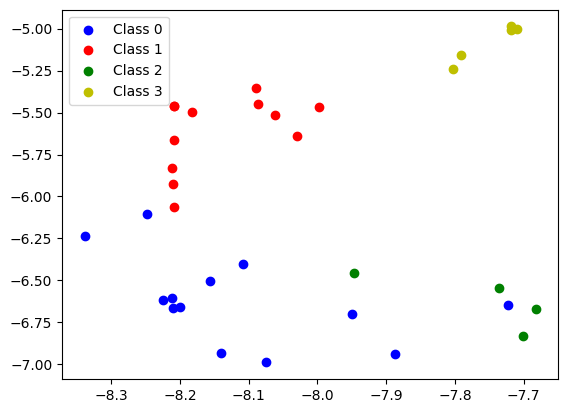

In [38]:
colors = ['b', 'r', 'g', 'y']

for label in range(4):
    class_indices = deepwalk_y == label
    
    class_data = tsne_deepwalk[class_indices]
    plt.scatter(class_data[:, 0], class_data[:, 1], c=colors[label], label=f"Class {label}")

plt.legend()
plt.show()